# Project Name: Predicting Home Prices in Banglore using ML and Auto SK Learn

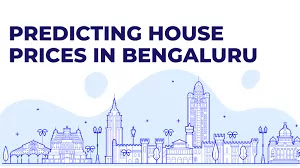

## Context:
### What are the things that a potential home buyer considers before purchasing a house? The location, the size of the property, vicinity to offices, schools, parks, restaurants, hospitals or the stereotypical white picket fence? What about the most important factor — the price?

Dataset is downloaded from here: https://www.kaggle.com/amitabhajoy/bengaluru-house-price-data

### We will be using different ML and Auto SK Learn Library (Auto ML) for this project.

## Time Line of the Project:
- Data Analysis
- Feature Engineering
- Model Building using ML
- Model Building using Auto SK Learn

### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 

<h2 style='color:blue'>Data Load: Load banglore home prices into a dataframe</h2>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/bengaluru_house_prices.csv')
df1.head()

In [ ]:
df1.head()

In [ ]:
df1.shape

In [ ]:
df1['area_type'].value_counts()

**Drop features that are not required to build our model**

In [ ]:
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.shape

<h2 style='color:blue'>Data Cleaning: Handle NA values</h2>

In [ ]:
df2.isnull().sum()

In [ ]:
df3 = df2.dropna()

In [ ]:
df3.shape

<h2 style='color:blue'>Feature Engineering</h2>

**Add new feature(integer) for bhk (Bedrooms Hall Kitchen)**

In [ ]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

In [ ]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None   

In [ ]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(2)

**Add new feature called price per square feet**

In [ ]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

In [ ]:
df5.to_csv("bhp.csv",index=False)

**Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations**

In [ ]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

In [ ]:
location_stats.values.sum()

In [ ]:
len(location_stats[location_stats>10])

In [ ]:
len(location_stats)

<h2 style="color:blue">Dimensionality Reduction</h2>

**Any location having less than 10 data points will be tagged as "other" location. This way number of categories can be reduced by huge amount. It will help us with having fewer dummy columns**

In [ ]:
location_stats_less_than_10 = location_stats[location_stats<=10]

In [ ]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

<h2 style="color:blue">Outlier Removal Using Logic</h2>

**Normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. Example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft**

In [ ]:
df5[df5.total_sqft/df5.bhk<300].head()

In [ ]:
df5.shape

In [ ]:
df5.price_per_sqft.describe()

**Here we find that min price per sqft is 267 rs/sqft whereas max is 176470, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation**

In [ ]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df6 = remove_pps_outliers(df5)
df6.shape

**Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like**

In [ ]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df6,"Rajaji Nagar")

In [ ]:
plot_scatter_chart(df6,"Hebbal")

In [ ]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df6.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

<h2 style='color:blue'>Outlier Removal Using Bathrooms Feature</h2>

In [ ]:
df6.bath.unique()

In [ ]:
plt.hist(df6.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [ ]:
df6[df6.bath>10]

**It is unusual to have 2 more bathrooms than number of bedrooms in a home**

In [ ]:
df6[df6.bath>df6.bhk+2]

In [ ]:
df7 = df6[df6.bath<df6.bhk+2]
df7.shape

In [ ]:
df8 = df7.drop(['size','price_per_sqft'],axis='columns')
df8.head(3)

<h2 style='color:blue'>Use One Hot Encoding For Location</h2>

In [ ]:
dummies = pd.get_dummies(df8.location)
dummies.head(3)

In [ ]:
df9 = pd.concat([df8,dummies.drop('other',axis='columns')],axis='columns')
df9.head()

In [ ]:
df10 = df9.drop('location',axis='columns')

In [ ]:
df10

<h2 style='color:blue'>Build a Model Now...</h2>

In [ ]:
X = df10.drop(['price'],axis='columns')
y = df10.price

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [ ]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

<h2 style='color:blue'>Use K Fold cross validation to measure accuracy of LinearRegression model</h2>

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

**We can see that in 5 iterations we get a score above 75% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score.**

<h2 style='color:blue'>Find best model using GridSearchCV</h2>

In [ ]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

In [ ]:
pred= lr_clf.predict(X_test)

In [ ]:
import seaborn as sns
sns.displot(y_test-pred)

**Based on above results we can say that LinearRegression gives the best score. Hence we will use that.**

# Using Auto SK Learn(Auto ML)

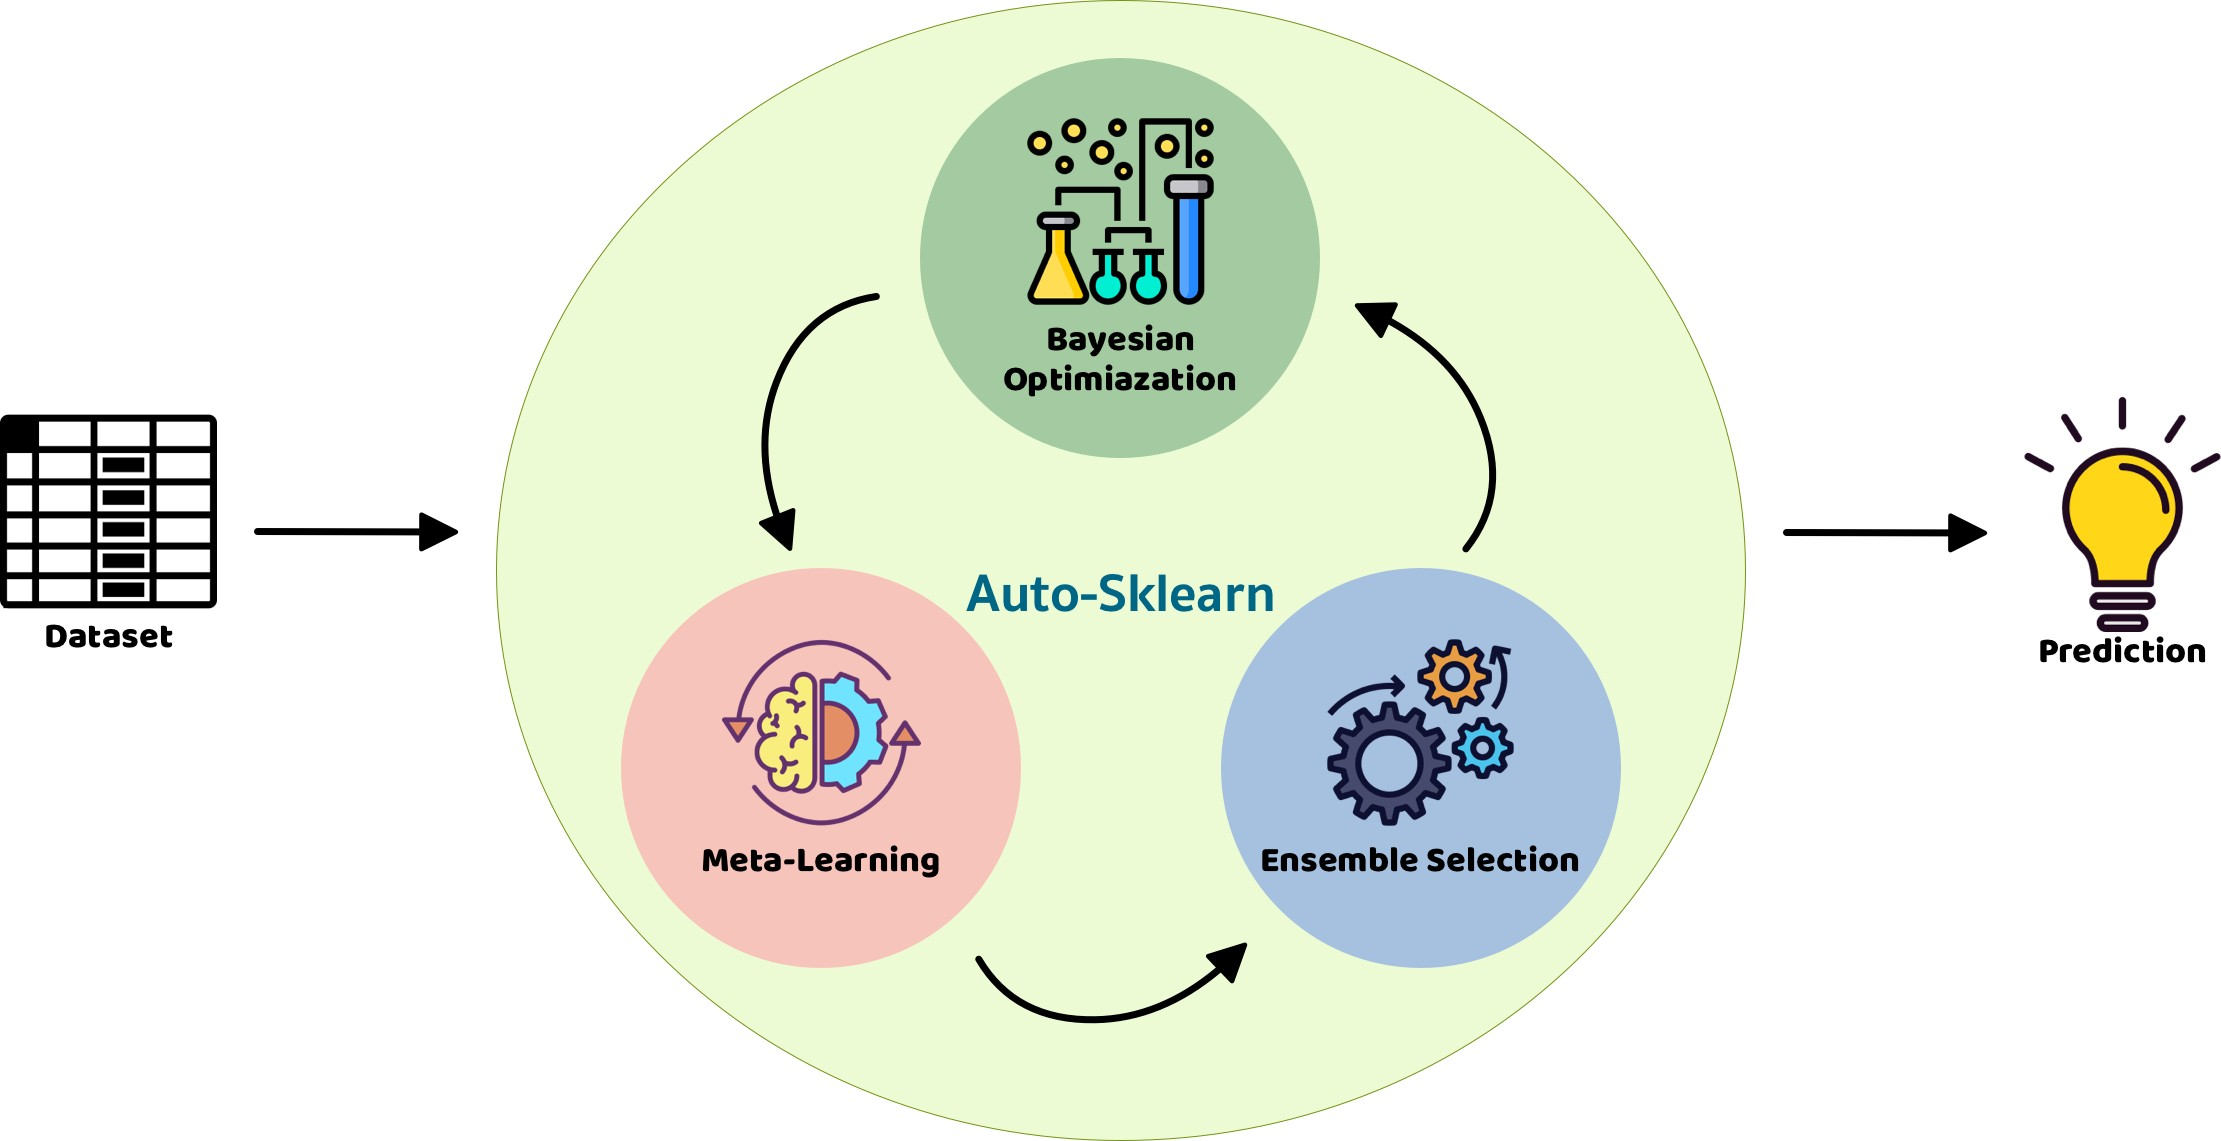

## Auto SK Learn: 
### auto-sklearn frees a machine learning user from algorithm selection and hyperparameter tuning. It leverages recent advantages in Bayesian optimization, meta-learning and ensemble construction.

In [ ]:
!apt-get install swig -y
!pip install Cython numpy
!pip install auto-sklearn

In [ ]:
import autosklearn

In [ ]:
import autosklearn.regression as reg

### We will use the same data we used for previous ML models

In [ ]:
X_train.shape

In [ ]:
automl = reg.AutoSklearnRegressor(time_left_for_this_task=120,per_run_time_limit=30)

In [ ]:
automl.fit(X_train,y_train)

In [ ]:
print(automl.leaderboard())

In [ ]:
print(automl.show_models())

In [ ]:
ypred2= automl.predict(X_test)

In [ ]:
ypred2

In [ ]:
import seaborn as sns
plt.style.use("ggplot")
plt.figure(figsize=(12,8))
sns.distplot(y_test-ypred2)
plt.show()

In [ ]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, ypred2))
print('MSE:', metrics.mean_squared_error(y_test, ypred2))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ypred2)))

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
print('R2:', metrics.r2_score(y_test, ypred2))